In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from six import BytesIO
from PIL import Image
import torchvision.transforms as T
%matplotlib inline

In [2]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3636, done.
remote: Counting objects: 100% (3636/3636), done.
remote: Compressing objects: 100% (3033/3033), done.
remote: Total 3636 (delta 960), reused 1548 (delta 549), pack-reused 0
Receiving objects: 100% (3636/3636), 47.37 MiB | 13.00 MiB/s, done.
Resolving deltas: 100% (960/960), done.


In [3]:
!sudo apt install -y protobuf-compiler

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [4]:
cd models/research/

/content/models/research


In [5]:
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 14.5 MB 58.0 MB/s 
     |████████████████████████████████| 352 kB 78.7 MB/s 
     |████████████████████████████████| 2.3 MB 64.9 MB/s 
     |████████████████████████████████| 26.9 MB 1.2 MB/s 
     |████████████████████████████████| 67 kB 7.3 MB/s 
     |████████████████████████████████| 116 kB 82.4 MB/s 
     |████████████████████████████████| 662 kB 69.4 MB/s 
     |████████████████████████████████| 1.3 MB 71.2 MB/s 
     |

In [6]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
model_url_1 = "https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1"
model_url_2 = "https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1"

hub_model_1 = hub.load(model_url_1)
hub_model_2 = hub.load(model_url_2)

In [8]:
def load_image(path):
  image_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

In [14]:
img_tensor = load_image('/content/image2.jpg')

In [27]:
r1 = hub_model_1(img_tensor)
r2 = hub_model_2(img_tensor)

In [28]:
r1_result = {key:value.numpy() for key,value in r1.items()}
r2_result = {key:value.numpy() for key,value in r2.items()}

In [17]:
PATH_TO_LABELS = '/content/models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

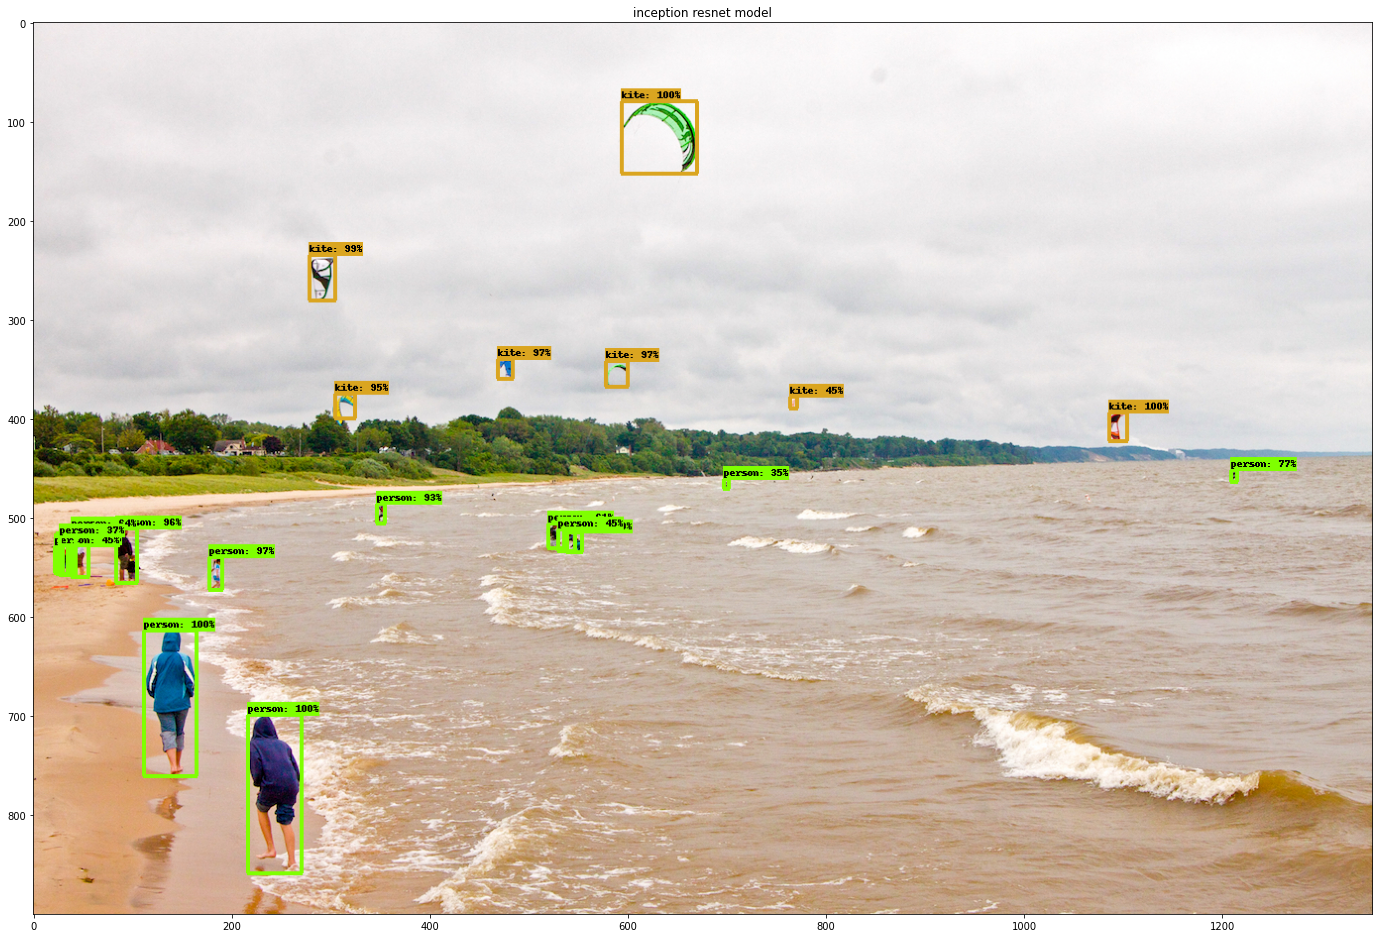

In [174]:
label_id_offset = 0
image_np_with_detections = img_tensor.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      r1_result['detection_boxes'][0],
      (r1_result['detection_classes'][0] + label_id_offset).astype(int),
      r1_result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.title('inception resnet model')
plt.show()

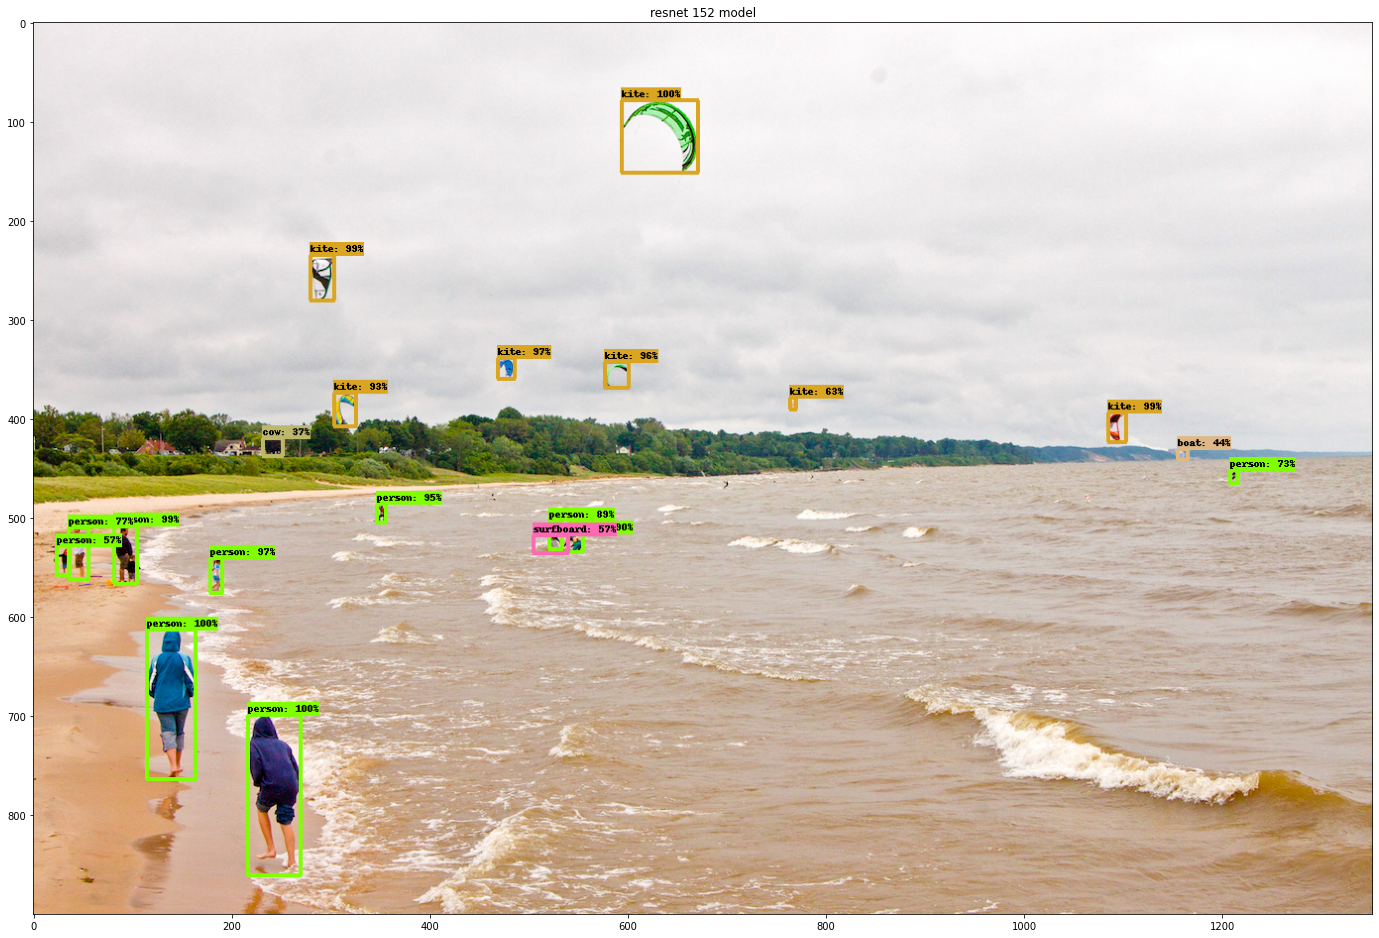

In [19]:
label_id_offset = 0
image_np_with_detections = img_tensor.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      r2_result['detection_boxes'][0],
      (r2_result['detection_classes'][0] + label_id_offset).astype(int),
      r2_result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.title('resnet 152 model')
plt.show()

In [29]:
r3 = {}
r3.update(r2)

In [ ]:
r3.update(r1)
r3

In [45]:
def final(raw_boxes,raw_scores):
    f = tf.image.non_max_suppression(raw_boxes,raw_scores,
    max_output_size =1,
    iou_threshold=2,
    score_threshold=float(0.02),
    name=None)
    
    return f

In [165]:
def IOU(box1, box2):
	""" We assume that the box follows the format:
		box1 = [x1,y1,x2,y2], and box2 = [x3,y3,x4,y4],
		where (x1,y1) and (x3,y3) represent the top left coordinate,
		and (x2,y2) and (x4,y4) represent the bottom right coordinate """
	x1, y1, x2, y2 = box1
	x3, y3, x4, y4 = box2
	x_inter1 = max(x1, x3)
	y_inter1 = max(y1, y3)
	x_inter2 = min(x2, x4)
	y_inter2 = min(y2, y4)
	width_inter = abs(x_inter2 - x_inter1)
	height_inter = abs(y_inter2 - y_inter1)
	area_inter = width_inter * height_inter
	width_box1 = abs(x2 - x1)
	height_box1 = abs(y2 - y1)
	width_box2 = abs(x4 - x3)
	height_box2 = abs(y4 - y3)
	area_box1 = width_box1 * height_box1
	area_box2 = width_box2 * height_box2
	area_union = area_box1 + area_box2 - area_inter
	iou = area_inter / area_union
	return iou
def nms(boxes, conf_threshold=0.7, iou_threshold=0.5):
  bbox_list_thresholded = []
  bbox_list_new = []
  print('adsga',boxes)
  boxes_sorted = sorted(boxes, reverse=True, key = lambda x : x[5])
  for box in boxes_sorted:
    if box[5] > conf_threshold:
        bbox_list_thresholded.append(box)
    else:
        pass
  while len(bbox_list_thresholded) > 0:
    current_box = bbox_list_thresholded.pop(0)
    bbox_list_new.append(current_box)
  for box in bbox_list_thresholded:
    if current_box[4] == box[4]:
      iou = IOU(current_box[:4], box[:4])
    if iou > iou_threshold:
      bbox_list_thresholded.remove(box)
  return bbox_list_new

In [166]:
box = []
for x in range(0,len(r3['detection_boxes'].numpy()[0])):
  b = []
  b.append(r3['detection_boxes'].numpy()[0].tolist()[x])
  b[0].append(r3['detection_classes'].numpy()[0].tolist())
  b[0].append(r3['detection_scores'].numpy()[0][x])
  box.append(b[0])

In [168]:
final_d = {}
b = []
s=[]
c =[]
for i in box:
  
  b.append(i[:4])
  c.append(i[4])
  s.append(i[5])
final_d['detection_boxes'] = np.array([b])
final_d['detection_classes'] = np.array(c)
final_d['detection_scores'] = np.array(s)

In [169]:
r1_result['detection_classes'][0]

array([ 1.,  1., 38., 38., 38., 38., 38.,  1.,  1., 38.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., 38.,  1.,  1.,  1., 16.,  1., 16.,  1., 38.,
        1., 38.,  1.,  1., 16.,  1.,  1., 16.,  1.,  1.,  1., 42.,  1.,
       38.,  1., 16., 38., 42., 16.,  1.,  1.,  1.,  1.,  1.,  1., 16.,
       16., 42.,  1., 42.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 38.,  1.,
       42.,  9., 42., 38., 20.,  1., 16., 18.,  1.,  1., 42., 42., 38.,
        1.,  1., 16., 16., 16., 16.,  1., 37., 38., 42., 21.,  1., 41.,
       16.,  1., 38., 16.,  1., 42., 10., 38., 27.], dtype=float32)

In [170]:
final_d['detection_classes'][0]

array([ 1.,  1., 38., 38., 38., 38., 38.,  1.,  1., 38.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., 38.,  1.,  1.,  1., 16.,  1., 16.,  1., 38.,
        1., 38.,  1.,  1., 16.,  1.,  1., 16.,  1.,  1.,  1., 42.,  1.,
       38.,  1., 16., 38., 42., 16.,  1.,  1.,  1.,  1.,  1.,  1., 16.,
       16., 42.,  1., 42.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 38.,  1.,
       42.,  9., 42., 38., 20.,  1., 16., 18.,  1.,  1., 42., 42., 38.,
        1.,  1., 16., 16., 16., 16.,  1., 37., 38., 42., 21.,  1., 41.,
       16.,  1., 38., 16.,  1., 42., 10., 38., 27.])

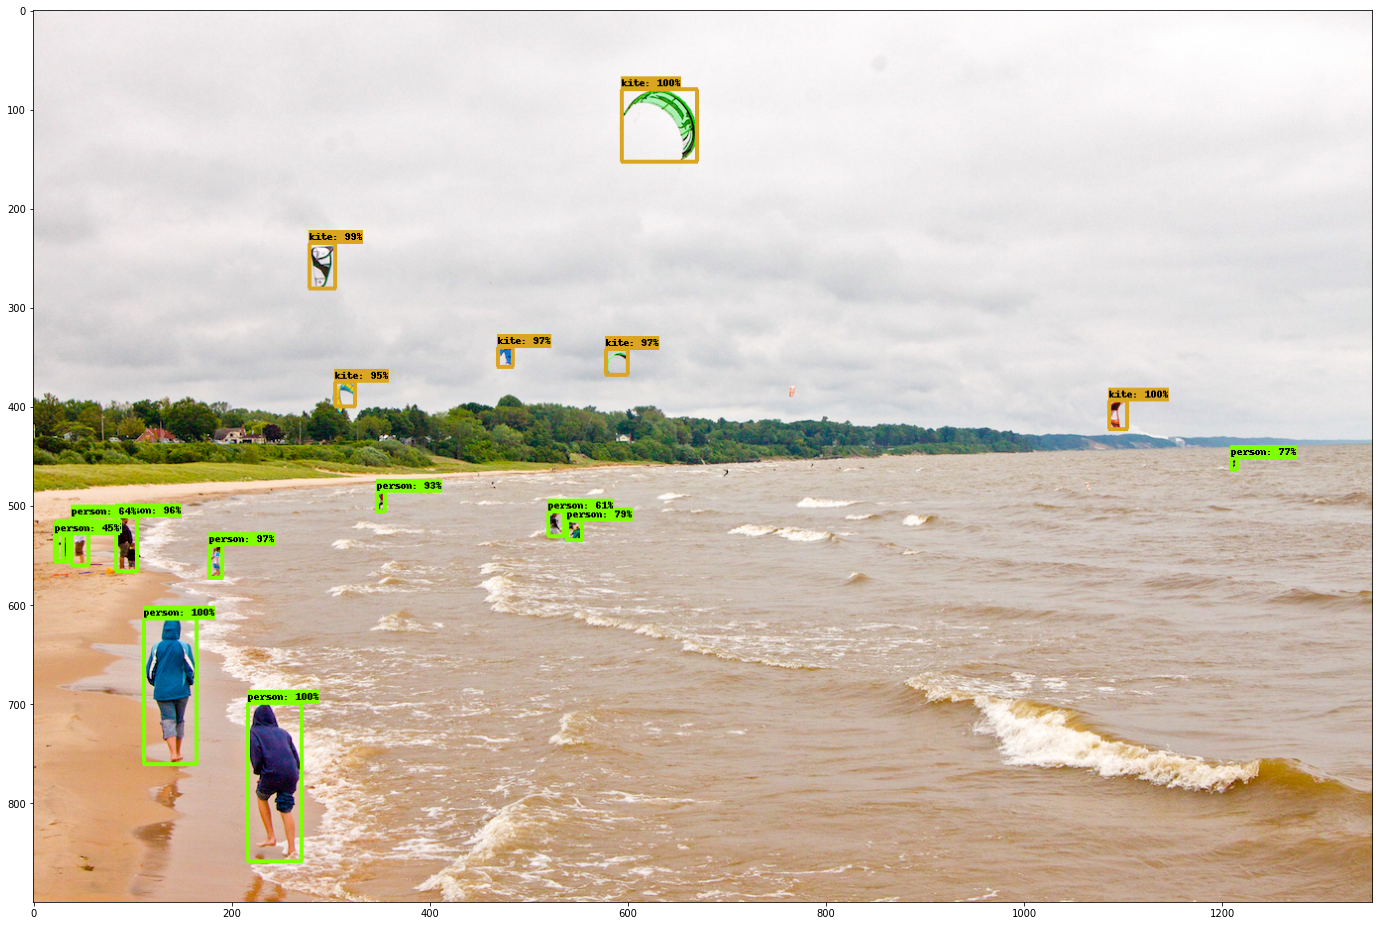

In [173]:
label_id_offset = 0
image_np_with_detections = img_tensor.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      final_d['detection_boxes'][0],
      (final_d['detection_classes'][0] + label_id_offset).astype(int),
      final_d['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.45,
      agnostic_mode=False)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()